# Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
# connect to sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# view all classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# create a session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# find the last date in the dataset
date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
date

'2017-08-23'

In [11]:
# calculate the date 1 year ago from the last date
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prev_year

datetime.date(2016, 8, 23)

In [14]:
# perform a query to retrieve the data and precipitation scores from the last year
precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# save the query results as a Pandas DataFrame and set index to date column
pcp_df = pd.DataFrame(precipitation)
pcp_df = pcp_df.set_index("date")

# sort the dataframe by date
pcp_df = pcp_df.sort_values(by = "date")
pcp_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


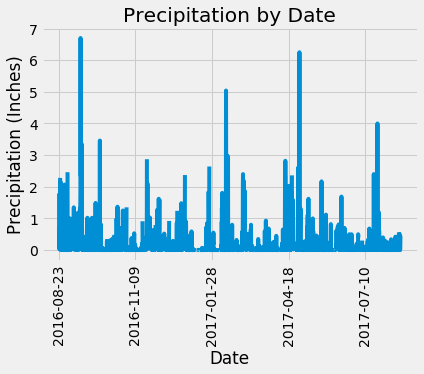

In [15]:
# use Pandas Plotting with Matplotlib to plot the data
pcp_df.plot(rot = 90, legend = False)
plt.title("Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.show()

In [16]:
# use Pandas to calculate the summary statistics for the precipitation data
summary_df = pcp_df.describe()
summary_df

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# design a query to show how many stations are available in this dataset
session.query(Station.station).count()

9

In [18]:
# what are the most active stations? (i.e. what stations have the most rows?)
# list the stations and the counts in descending order
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# choose the station with the highest number of temperature observations 
# query the last 12 months of temperature observation data for this station
temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= prev_year).all()

# save the query results as a Pandas DataFrame and set index to date column
temp_df = pd.DataFrame(temp)
temp_df = temp_df.set_index("date")

# sort the dataframe by date
temp_df = temp_df.sort_values(by = "date")
temp_df

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


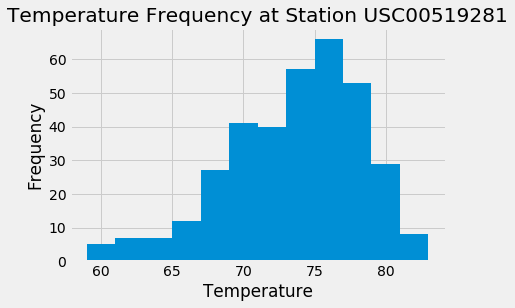

In [21]:
# plot the results as a histogram
temp_df.hist(bins = 12)
plt.title("Temperature Frequency at Station USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps("2017-07-22", "2017-08-05")[0]
print(tmin, tavg, tmax)

72.0 78.79268292682927 84.0


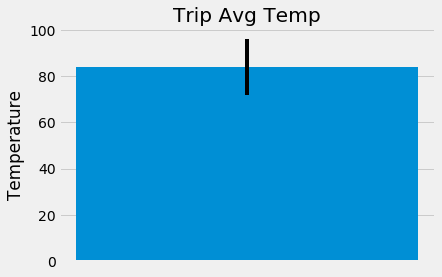

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1, tmax, yerr=tmax-tmin)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")
plt.xticks([])
plt.show()

In [75]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

rainfall = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= "2017-07-22").\
    filter(Measurement.date <= "2017-08-05").\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_df = pd.DataFrame(rainfall, columns = ["Station", "Name", "Lat", "Long", "Elevation", "Total Precip."])
rainfall_df

,Station,Name,Lat,Long,Elevation,Total Precip.
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.55
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.90
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.63
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.99
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.12
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.05
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.01


In [63]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [70]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start = "2017-07-22"
end = "2017-08-05"

# Use the start and end date to create a range of dates
dates = pd.date_range(start, end)

# Strip off the year and save a list of %m-%d strings
daymonth = dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in daymonth:
    normals.append(*daily_normals(day))

normals

[(69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0),
 (68.0, 76.58181818181818, 83.0),
 (69.0, 76.46428571428571, 82.0),
 (69.0, 76.47058823529412, 83.0),
 (69.0, 77.35185185185185, 84.0),
 (72.0, 77.03571428571429, 83.0),
 (67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0)]

In [81]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dailynorms_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])
dailynorms_df["trip_dates"] = dates
dailynorms_df = dailynorms_df.set_index("trip_dates")
dailynorms_df

,tmin,tavg,tmax
trip_dates,,,
2017-07-22,69.0,75.788462,81.0
2017-07-23,70.0,76.203704,84.0
2017-07-24,69.0,76.555556,81.0
2017-07-25,67.0,76.890909,84.0
2017-07-26,71.0,76.442308,86.0
2017-07-27,68.0,76.581818,83.0
2017-07-28,69.0,76.464286,82.0
2017-07-29,69.0,76.470588,83.0
2017-07-30,69.0,77.351852,84.0


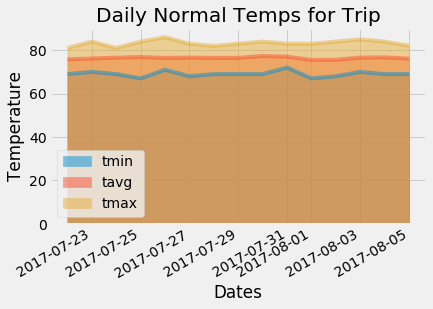

In [84]:
# Plot the daily normals as an area plot with `stacked=False`
dailynorms_df.plot(kind = "area", stacked = False, x_compat = True)
plt.title("Daily Normal Temps for Trip")
plt.ylabel("Temperature")
plt.xlabel("Dates")
plt.show()